In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
import os
from datetime import datetime
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
 
import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv("./egyesitett_jo.csv")
data["Date"] = pd.to_datetime(data["Date"])
data

,Date,Close,Volume,Open,High,Low,Name
0,2023-10-19,128.40,60961360,130.57,132.24,127.47,AMZN
1,2023-10-18,128.13,42699480,129.90,130.67,127.51,AMZN
2,2023-10-17,131.47,49344550,130.39,132.58,128.71,AMZN
3,2023-10-16,132.55,42832920,130.69,133.07,130.43,AMZN
4,2023-10-13,129.79,45824690,132.98,133.31,128.95,AMZN
...,...,...,...,...,...,...,...
12580,2013-10-25,11.31,113661738,11.61,11.63,11.12,TSLA
12581,2013-10-24,11.54,161740419,11.00,11.63,10.86,TSLA
12582,2013-10-23,10.97,199788950,11.26,11.45,10.68,TSLA
12583,2013-10-22,11.44,170788865,11.37,11.85,11.07,TSLA


# Grid Search függvények

In [3]:
def evaluate_arima_model(X, arima_order):
    #Tanító-teszt felbontás 0.9-0.1 arányban
    train_size = int(len(X) * 0.9)
    train, test = X[0:train_size], X[train_size:]

    #Modell tanítása
    model = ARIMA(train, order=arima_order)
    model_fit = model.fit()

    #A következő napra adott predikció
    predictions = []
    for t in range(len(test)):
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)

        #Modell frissítése a legutóbbi tesztadattal
        model_fit = model_fit.append(test[t:t+1], refit=False)

    #MSE
    error = mean_squared_error(test, predictions)
    return error

In [4]:
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order, mse))
                    
                except Exception as e:
                    print('ARIMA%s - Error: %s' % (order, str(e)))
                    continue
                    
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

Itt azért van szükség a try-exceptre, mert megadhatunk olyan paramétereket, amiket az ARIMA modell nem talál értelmesnek.

In [5]:
amazon_close = np.array(data[data["Name"] == "AMZN"].sort_values(by = "Date")[["Close"]].values)
apple_close = np.array(data[data["Name"] == "AAPL"].sort_values(by = "Date")[["Close"]].values)
microsoft_close = np.array(data[data["Name"] == "MSFT"].sort_values(by = "Date")[["Close"]].values)
starbucks_close = np.array(data[data["Name"] == "SBUX"].sort_values(by = "Date")[["Close"]].values)
tesla_close = np.array(data[data["Name"] == "TSLA"].sort_values(by = "Date")[["Close"]].values)


amazon_close

array([[ 16.32],
       [ 16.63],
       [ 16.34],
       ...,
       [131.47],
       [128.13],
       [128.4 ]])

# A legjobb kiválasztása adott p, d, q értékekre

In [6]:
%%time
p_values = range(1, 4)
d_values = range(0, 3)
q_values = range(0, 4)
evaluate_models(tesla_close, p_values, d_values, q_values)

ARIMA(1, 0, 0) MSE=54.715
ARIMA(1, 0, 1) MSE=54.774
ARIMA(1, 0, 2) MSE=54.734
ARIMA(1, 0, 3) MSE=54.748
ARIMA(1, 1, 0) MSE=54.806
ARIMA(1, 1, 1) MSE=54.712
ARIMA(1, 1, 2) MSE=54.727
ARIMA(1, 1, 3) MSE=54.530
ARIMA(1, 2, 0) MSE=78.557
ARIMA(1, 2, 1) MSE=54.837
ARIMA(1, 2, 2) MSE=55.092
ARIMA(1, 2, 3) MSE=55.542
ARIMA(2, 0, 0) MSE=54.775
ARIMA(2, 0, 1) MSE=54.736
ARIMA(2, 0, 2) MSE=54.502
ARIMA(2, 0, 3) MSE=54.711
ARIMA(2, 1, 0) MSE=54.767
ARIMA(2, 1, 1) MSE=54.555
ARIMA(2, 1, 2) MSE=54.711
ARIMA(2, 1, 3) MSE=54.674
ARIMA(2, 2, 0) MSE=71.775
ARIMA(2, 2, 1) MSE=54.798
ARIMA(2, 2, 2) MSE=55.597
ARIMA(2, 2, 3) MSE=54.716
ARIMA(3, 0, 0) MSE=54.734
ARIMA(3, 0, 1) MSE=54.714
ARIMA(3, 0, 2) MSE=54.682
ARIMA(3, 0, 3) MSE=54.610
ARIMA(3, 1, 0) MSE=54.775
ARIMA(3, 1, 1) MSE=54.775
ARIMA(3, 1, 2) MSE=55.486
ARIMA(3, 1, 3) MSE=54.700
ARIMA(3, 2, 0) MSE=61.511
ARIMA(3, 2, 1) MSE=54.805
ARIMA(3, 2, 2) MSE=55.786
ARIMA(3, 2, 3) MSE=54.705
Best ARIMA(2, 0, 2) MSE=54.502
CPU times: total: 17min 55s
Wall 

In [7]:
%%time
p_values = [1, 4, 7]
d_values = range(0, 3)
q_values = [1, 3, 5]
evaluate_models(tesla_close, p_values, d_values, q_values)

ARIMA(1, 0, 1) MSE=54.774
ARIMA(1, 0, 3) MSE=54.748
ARIMA(1, 0, 5) MSE=53.672
ARIMA(1, 1, 1) MSE=54.712
ARIMA(1, 1, 3) MSE=54.530
ARIMA(1, 1, 5) MSE=54.961
ARIMA(1, 2, 1) MSE=54.837
ARIMA(1, 2, 3) MSE=55.542
ARIMA(1, 2, 5) MSE=55.801
ARIMA(4, 0, 1) MSE=54.701
ARIMA(4, 0, 3) MSE=54.141
ARIMA(4, 0, 5) MSE=55.477
ARIMA(4, 1, 1) MSE=54.063
ARIMA(4, 1, 3) MSE=53.529
ARIMA(4, 1, 5) MSE=56.242
ARIMA(4, 2, 1) MSE=54.130
ARIMA(4, 2, 3) MSE=54.925
ARIMA(4, 2, 5) MSE=56.035
ARIMA(7, 0, 1) MSE=55.674
ARIMA(7, 0, 3) MSE=56.387
ARIMA(7, 0, 5) MSE=56.538
ARIMA(7, 1, 1) MSE=55.942
ARIMA(7, 1, 3) MSE=55.764
ARIMA(7, 1, 5) MSE=55.942
ARIMA(7, 2, 1) MSE=54.984
ARIMA(7, 2, 3) MSE=55.888
ARIMA(7, 2, 5) MSE=53.956
Best ARIMA(4, 1, 3) MSE=53.529
CPU times: total: 11min 39s
Wall time: 11min 40s


Hosszú ideig fut a Grid Search mindkét esetben. Az első esetben egymás melletti számokra futtatuk a programot, a másodikban pedig p értéke 3-asával, q értéke 2-esével változik. Az utóbbinak talán több értelme van, mert nem nézi (1, 0, 1) modell mellett (2, 0, 1)-re is, ami valószínűleg nagyon hasonló értéked adna, hanem egyből a (4, 0, 1) modellt értékeli ki. Tehát így átugorhatjuk az optimális konfigurációt, de a megtalált paraméterek közel lesznek az optimálishoz, és meg tudtunk nézni egy nagyobb range-et is.

# Grid search és plot a különböző részvényekre

In [8]:
def evaluate_models2(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order, mse))
                    
                except Exception as e:
                    print('ARIMA%s - Error: %s' % (order, str(e)))
                    continue
                    
    return (best_cfg, best_score)

In [9]:
def best_arima_with_plotting(stock):
    stock_close = np.array(data[data["Name"] == stock].sort_values(by = "Date")[["Close"]].values)
    p_values = range(1, 4)
    d_values = range(0, 2)
    q_values = range(0, 2)
    best_cfg, best_score = evaluate_models2(stock_close, p_values, d_values, q_values)
    
    #Tanító-teszt felbontás 0.9-0.1 arányban
    train_size = int(len(stock_close) * 0.9)
    train, test = stock_close[0:train_size], stock_close[train_size:]

    #Modell tanítása
    model = ARIMA(train, order = best_cfg)
    model_fit = model.fit()

    #Predikció
    predictions = []
    for t in range(len(test)):
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)

        #Modell frissítése a legújabb tesztadattal
        model_fit = model_fit.append(test[t:t+1], refit=False)
        
    #Time index létrehozása az ábrázoláshoz
    time_index = range(len(train) + len(test))
    prediction_index = range(len(train), len(train) + len(predictions))
    
    stock_data = data[data["Name"] == stock].sort_values(by = "Date")

    plt.figure(figsize=(10, 8))
    

    #Plotolás
    plt.plot(stock_data["Date"].iloc[time_index[:len(train)]], train, label='Training Data')
    plt.plot(stock_data["Date"].iloc[time_index[len(train):]], test, label='Test Data')
    plt.plot(stock_data["Date"].iloc[prediction_index], predictions, label='Predictions', color='green', linestyle = "dashed", alpha = 0.7)

    plt.xlabel('Date')
    plt.ylabel('Close price')
    plt.title(f'ARIMA Model Prediction for {stock}')
    plt.legend()

    plt.show()

ARIMA(1, 0, 0) MSE=6.561
ARIMA(1, 0, 1) MSE=6.563
ARIMA(1, 1, 0) MSE=6.564
ARIMA(1, 1, 1) MSE=6.566
ARIMA(2, 0, 0) MSE=6.563
ARIMA(2, 0, 1) MSE=6.565
ARIMA(2, 1, 0) MSE=6.574
ARIMA(2, 1, 1) MSE=6.572
ARIMA(3, 0, 0) MSE=6.573
ARIMA(3, 0, 1) MSE=6.572
ARIMA(3, 1, 0) MSE=6.590
ARIMA(3, 1, 1) MSE=6.571


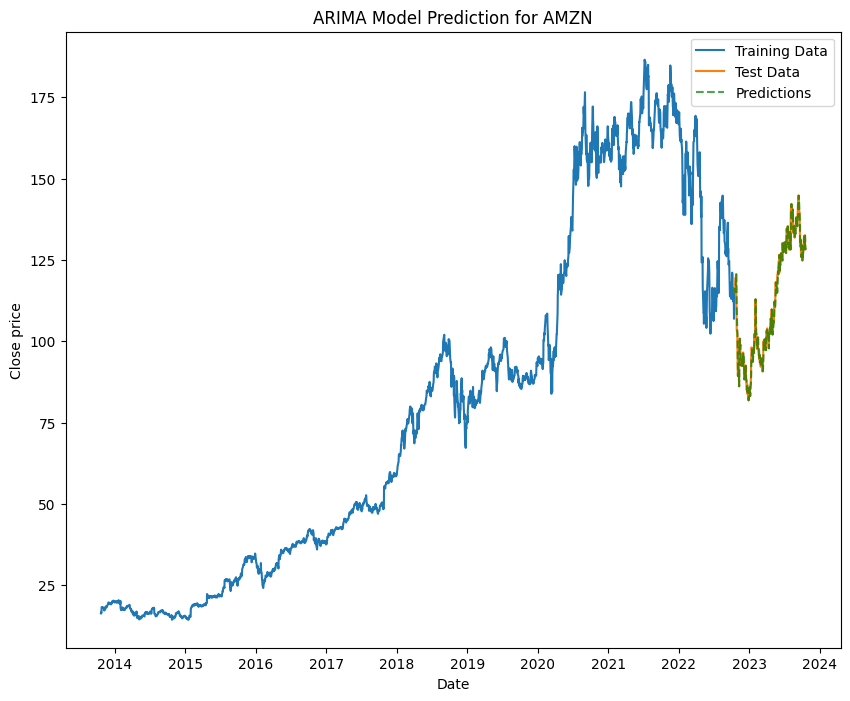

In [10]:
best_arima_with_plotting("AMZN")

ARIMA(1, 0, 0) MSE=6.630
ARIMA(1, 0, 1) MSE=6.687
ARIMA(1, 1, 0) MSE=6.685
ARIMA(1, 1, 1) MSE=6.670
ARIMA(2, 0, 0) MSE=6.687
ARIMA(2, 0, 1) MSE=6.668
ARIMA(2, 1, 0) MSE=6.673
ARIMA(2, 1, 1) MSE=6.669
ARIMA(3, 0, 0) MSE=6.675
ARIMA(3, 0, 1) MSE=6.677
ARIMA(3, 1, 0) MSE=6.685
ARIMA(3, 1, 1) MSE=6.688


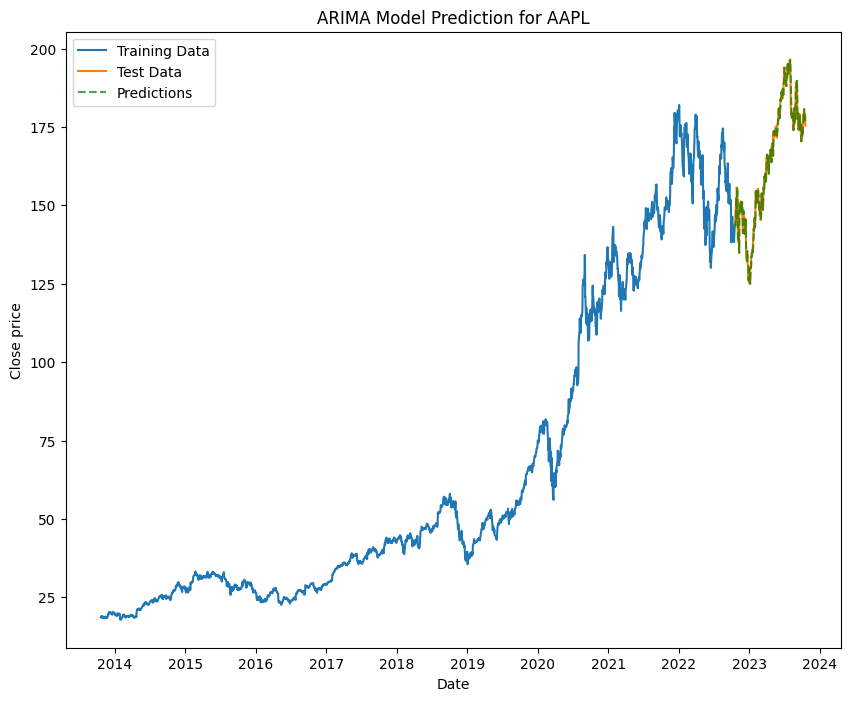

In [11]:
best_arima_with_plotting("AAPL")

ARIMA(1, 0, 0) MSE=54.715
ARIMA(1, 0, 1) MSE=54.774
ARIMA(1, 1, 0) MSE=54.806
ARIMA(1, 1, 1) MSE=54.712
ARIMA(2, 0, 0) MSE=54.775
ARIMA(2, 0, 1) MSE=54.736
ARIMA(2, 1, 0) MSE=54.767
ARIMA(2, 1, 1) MSE=54.555
ARIMA(3, 0, 0) MSE=54.734
ARIMA(3, 0, 1) MSE=54.714
ARIMA(3, 1, 0) MSE=54.775
ARIMA(3, 1, 1) MSE=54.775


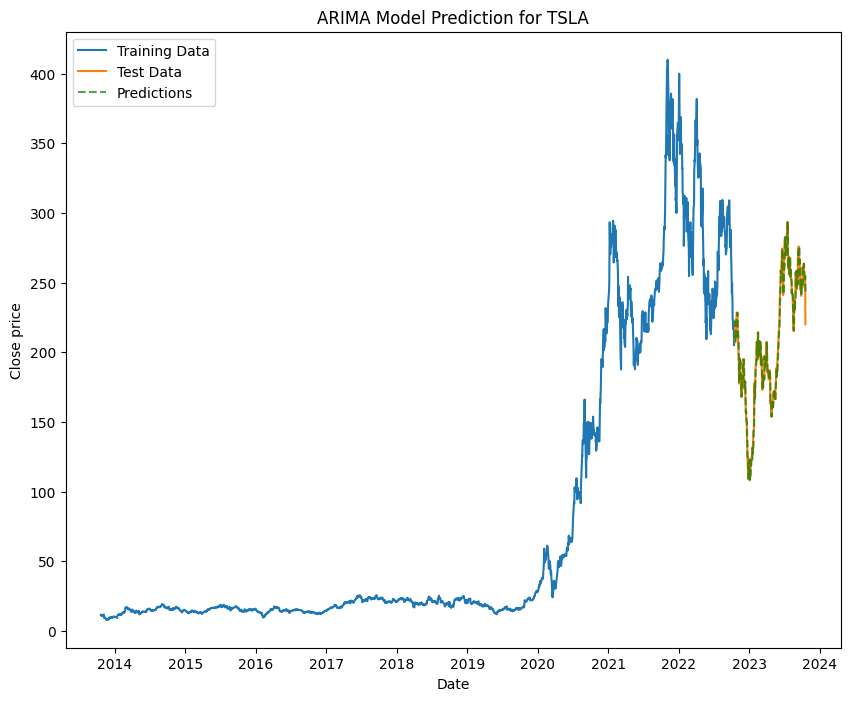

In [12]:
best_arima_with_plotting("TSLA")

ARIMA(1, 0, 0) MSE=25.759
ARIMA(1, 0, 1) MSE=26.282
ARIMA(1, 1, 0) MSE=26.526
ARIMA(1, 1, 1) MSE=26.794
ARIMA(2, 0, 0) MSE=26.561
ARIMA(2, 0, 1) MSE=26.825
ARIMA(2, 1, 0) MSE=26.801
ARIMA(2, 1, 1) MSE=26.325
ARIMA(3, 0, 0) MSE=26.839
ARIMA(3, 0, 1) MSE=26.831
ARIMA(3, 1, 0) MSE=26.706
ARIMA(3, 1, 1) MSE=26.790


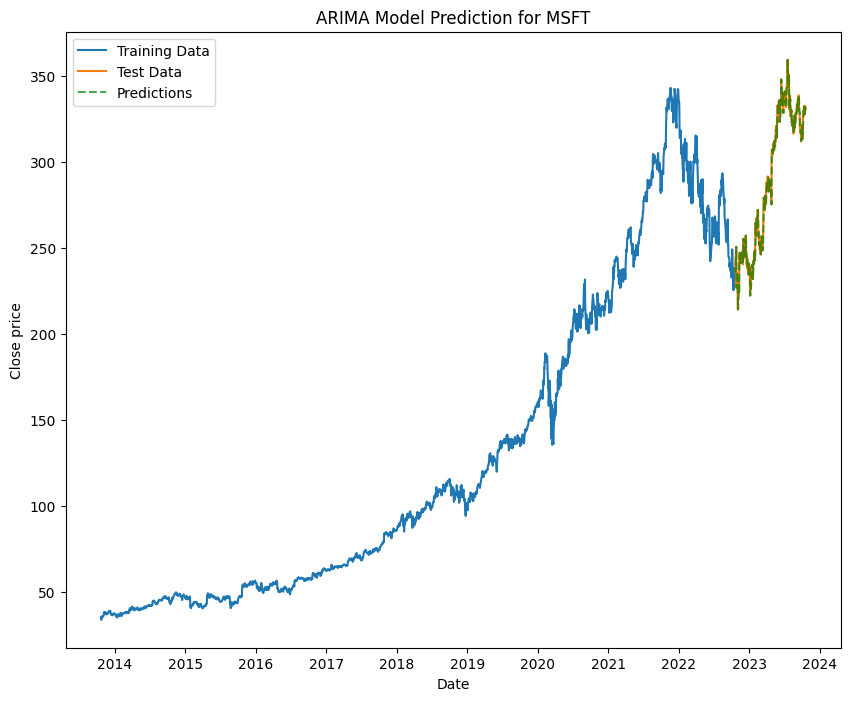

In [13]:
best_arima_with_plotting("MSFT")

ARIMA(1, 0, 0) MSE=2.220
ARIMA(1, 0, 1) MSE=2.231
ARIMA(1, 1, 0) MSE=2.232
ARIMA(1, 1, 1) MSE=2.234
ARIMA(2, 0, 0) MSE=2.233
ARIMA(2, 0, 1) MSE=2.235
ARIMA(2, 1, 0) MSE=2.235
ARIMA(2, 1, 1) MSE=2.235
ARIMA(3, 0, 0) MSE=2.235
ARIMA(3, 0, 1) MSE=2.235
ARIMA(3, 1, 0) MSE=2.234
ARIMA(3, 1, 1) MSE=2.232


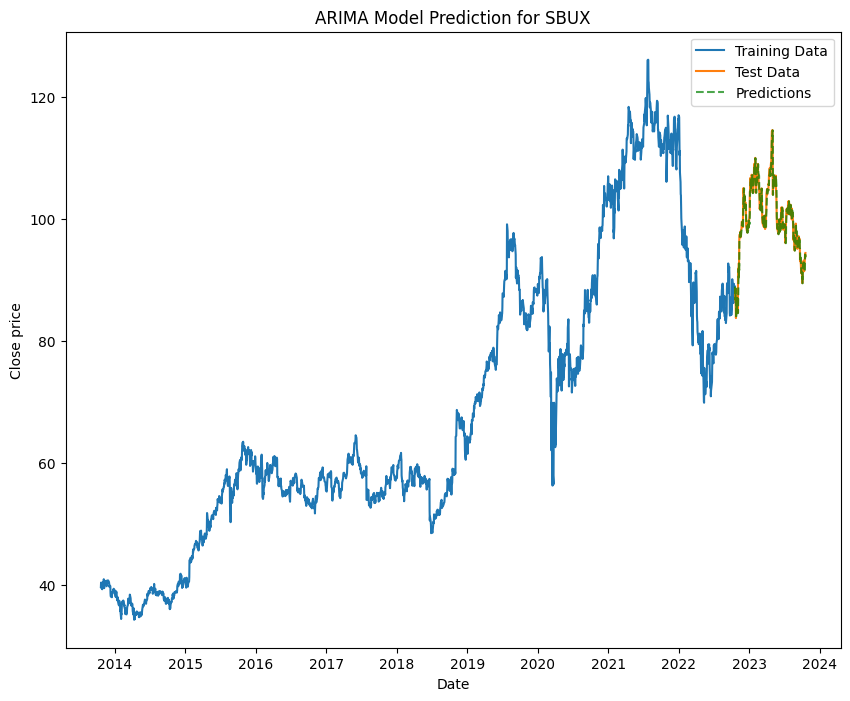

In [14]:
best_arima_with_plotting("SBUX")

# Dinamikus előrejelzés (Dynamic forecast)

In [15]:
train_size = int(len(amazon_close) * 0.95)
train, test = amazon_close[0:train_size], amazon_close[train_size:]

model = ARIMA(amazon_close, order=(30, 4, 30))
model_fit = model.fit()

#Dinamikus predikció, ami a teszthalmaz méretének megfelelő méretű   
dynamic_predictions = model_fit.get_prediction(start=-len(test), dynamic=True)

predicted_mean = dynamic_predictions.predicted_mean

conf_int = dynamic_predictions.conf_int()

#print(predicted_mean)

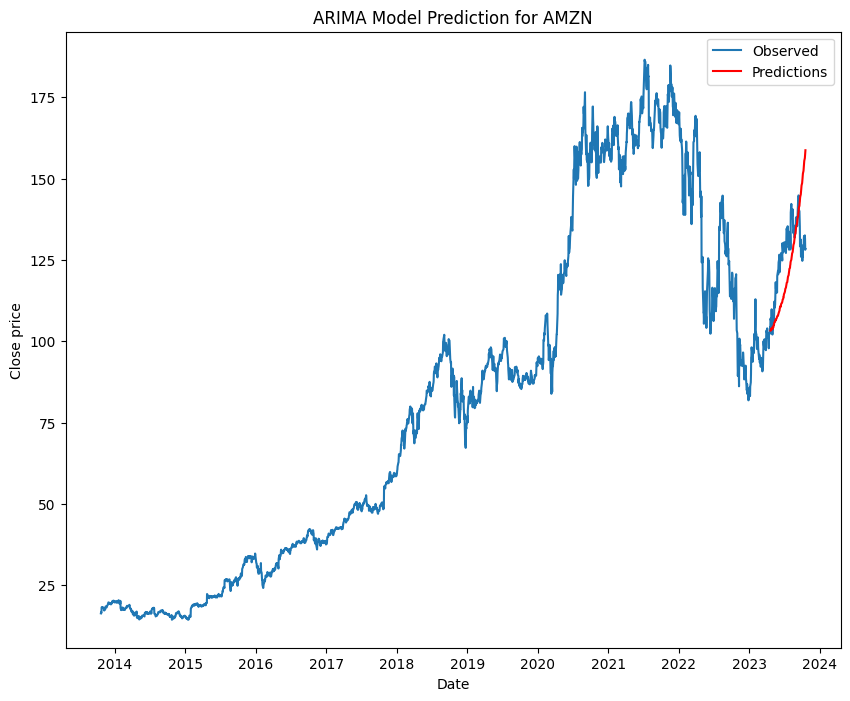

In [16]:
amazon_data = data[data["Name"] == "AMZN"].sort_values(by = "Date")

time_index = range(len(train) + len(test))
prediction_index = range(len(train), len(train) + len(predicted_mean))

plt.figure(figsize=(10, 8))


plt.plot(amazon_data["Date"], amazon_data["Close"], label='Observed')


plt.plot(amazon_data["Date"].iloc[prediction_index], predicted_mean, label='Predictions', color='red')

plt.xlabel('Date')
plt.ylabel('Close price')
plt.title(f'ARIMA Model Prediction for AMZN')
plt.legend()

plt.show()

Nagyjából eltalálja a trendet, de nem működik olyan jól.